In [1]:
# from patch_CAVI import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import matplotlib
import cv2
from patch_CAVI_unary import *
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

## CAVI helpers

In [209]:
def func(x):
    x = -x.abs()
    mult = torch.exp(-30.0 * x.max(0, keepdim=True)[0].max(1, keepdim=True)[0] ** 2)
    return mult * torch.exp(3.0 * x)

def reconstruct_img(out,H,W,stride,PSZ):
    rec = np.zeros([H,W,int(out.shape[-2]*out.shape[-1])])
    num_overlaps = np.zeros([H,W])
    itr = 0
    for i in range(out.shape[-2]):
        for j in range(out.shape[-1]):
            rec[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out[...,i,j].detach().cpu().numpy()
            num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
            itr = itr+1
    return np.divide(np.sum(rec,axis = -1),num_overlaps)


## Creating simple FOJ patches

C:\Users\Aneel\AppData\Local\Temp/ipykernel_23944/146494095.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  junctions = np.ones((H, W), dtype=np.bool)


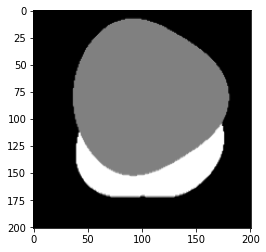

In [21]:
import numpy as np
import cv2


def perlin(x,y,seed=0):
    # permutation table
    #np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y


def get_curvature(rad):

    rad_t_plus_1  = np.concatenate([rad[1:], rad[:1]], axis=0)
    rad_t_minus_1 = np.concatenate([rad[-1:], rad[:-1]], axis=0)

    drad  = 0.5 * (rad_t_plus_1 - rad_t_minus_1) / (angle[1] - angle[0])
    d2rad = (rad_t_plus_1 - 2 * rad + rad_t_minus_1) / (angle[1] - angle[0]) ** 2

    curvature = np.abs(rad ** 2 + 2 * drad ** 2 - rad * d2rad) / np.sqrt((rad ** 2 + drad ** 2) ** 3)

    return curvature



H = W = 201
maxrad = H / 2.5
minrad = H / 4.0

RF = 21

num_imgs = 1

for i in range(num_imgs):

    img_np = np.zeros((H, W), dtype=np.uint8)
    edges = np.zeros((H, W), dtype=np.uint8)
    curvature_img = np.zeros((H, W), dtype=np.float32)
    junctions = np.ones((H, W), dtype=np.bool)

    axis_angle = np.random.rand() * 2 * np.pi

    colors = [255, 128] if np.random.rand() > 0.5 else [128, 255]
    for blob_id, clr in enumerate(colors):
        angle = np.linspace(0.0, 2*np.pi, 10001)[:-1]

        xp = 2.5 + 0.6 * np.cos(angle[np.newaxis, :])
        yp = 2.5 + 0.6 * np.sin(angle[np.newaxis, :])

        p = perlin(xp, yp)

        rad = minrad + (maxrad - minrad) * (0.5 + p)[0, :]

        
        xlist = rad * np.cos(angle) + 0.5 * H + 0.1 * H * np.cos(axis_angle + np.pi * (blob_id == 1))
        ylist = rad * np.sin(angle) + 0.5 * W + 0.1 * W * np.sin(axis_angle + np.pi * (blob_id == 1))

        pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
        pts = pts.reshape((1, -1, 2))

#         np.save(f'datasets/blobs_small/rad_{blob_id}_{i:03}.npy', rad)
#         np.save(f'datasets/blobs_small/pts_{blob_id}_{i:03}.npy', pts)
        
        
        curr_edges = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(img_np, pts, color=clr, lineType=cv2.LINE_AA)
        cv2.fillPoly(edges, pts, color=(0,))
        cv2.fillPoly(curr_edges, pts, color=(0,))
        cv2.fillPoly(curvature_img, pts, color=(0,))
        
        curvature = get_curvature(rad)
        for t in range(1000):
            clr = curvature[10*t:10*t+10].mean() / 0.02  # Not sure why 0.02, but that's the range
            cv2.polylines(curvature_img, pts[:, 10*t:10*t+10, :], False, (clr,), 1)
            cv2.polylines(curr_edges,    pts[:, 10*t:10*t+10, :], False, (255,), 1)
            cv2.polylines(edges,         pts[:, 10*t:10*t+10, :], False, (255,), 1)
            
        
        junctions &= (curr_edges > 128)


# img_np = cv2.resize(img_np, (55, 55), interpolation=cv2.INTER_AREA)
# edges = cv2.resize(edges, (55, 55), interpolation=cv2.INTER_AREA)
# junctions = cv2.resize(np.uint8(junctions) * 255, (55, 55), interpolation=cv2.INTER_AREA)
# curvature_img = cv2.resize(curvature_img, (55, 55), interpolation=cv2.INTER_AREA)

plt.imshow(img_np,cmap='gray')
img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
img = np.asarray(img/255.0,dtype=np.float32)

Beginning initialization...
Initialization iteration 0/30
Initialization iteration 5/30
Initialization iteration 10/30
Initialization iteration 15/30
Initialization iteration 20/30
Initialization iteration 25/30
Initialization done. Beginning refinement...
Refinement iteration 100/1000
Refinement iteration 200/1000
Refinement iteration 300/1000
Refinement iteration 400/1000
Refinement iteration 500/1000
Refinement iteration 600/1000
Refinement iteration 700/1000
Refinement iteration 800/1000
Refinement iteration 900/1000
Refinement iteration 1000/1000
Wall time: 59.4 s


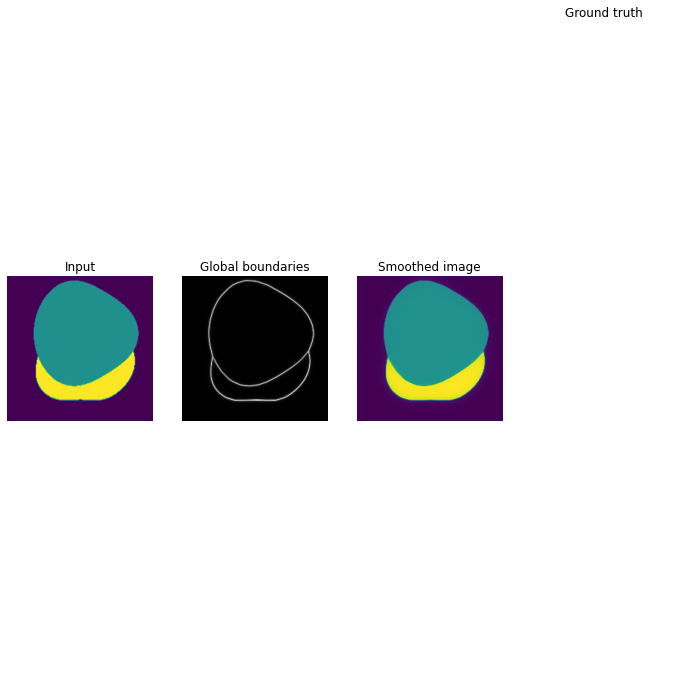

In [22]:
# Create opts object
opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 3
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.5
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 30
opts.num_refinement_iters     = 1000
opts.greedy_step_every_iters  = 50
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


# Define function for optimization (foj.optimize() may be used instead)
def foj_optimize_verbose():
    for i in range(foj.num_iters):
        if i == 0:
            print("Beginning initialization...")
        if i == opts.num_initialization_iters:
            print("Initialization done. Beginning refinement...")
        if i < opts.num_initialization_iters:
            if i % 5 == 0:
                print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
        else:
            if i % 100 == 0:
                print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
        foj.step(i)

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_verbose()       # Run optimization with some printing

# Compute smoothed image and boundary map
params = torch.cat([foj.angles, foj.x0y0], dim=1)
dists, _, patches = foj.get_dists_and_patches(params)
local_boundaries = foj.dists2boundaries(dists)
global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()
smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=[12, 12])
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(143)
plt.imshow(smoothed_img)
plt.title('Smoothed image')
plt.axis('off')
plt.subplot(144)
# plt.imshow(clean_img)
plt.title('Ground truth')
plt.axis('off');

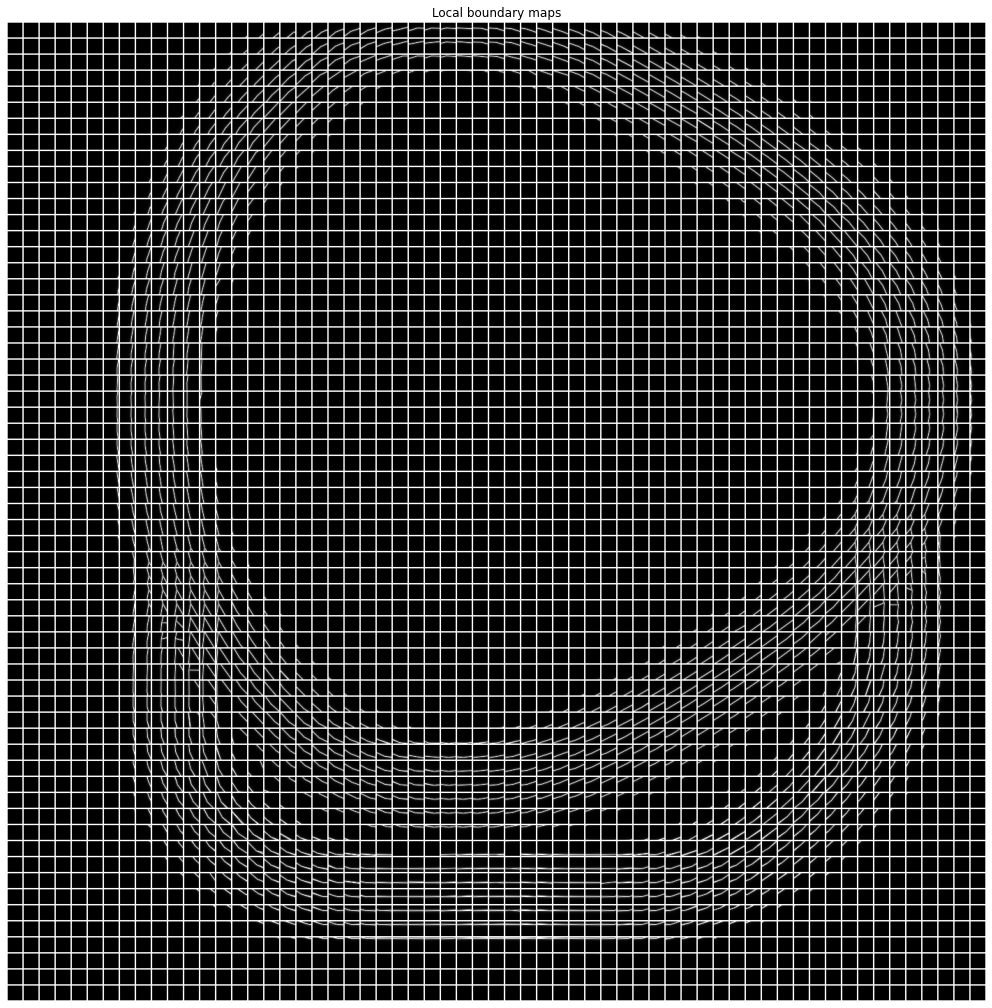

In [23]:
from utils import patchstack

boundary_vis = patchstack(local_boundaries)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(boundary_vis, cmap='gray')
plt.title('Local boundary maps')
plt.axis('off');


In [24]:
angles = torch.remainder(params[:, :3, :, :], 2 * np.pi)
angles = torch.sort(angles, dim=1)[0].detach().cpu().numpy()

t_angle1 = angles[0, 0, :, :]   # shape [N, 1, 1, H', W']
t_angle2 = angles[0, 1, :, :]   # shape [N, 1, 1, H', W']
t_angle3 = angles[0, 2, :, :]  # shape [N, 1, 1, H', W']

#ANGLES ARE SWAPPED BECUASE WEDGES ORDERED COUNTERCLOCKWISE
angle1 = np.remainder(t_angle1-t_angle3,2*np.pi)
angle3 = np.remainder(t_angle2-t_angle1,2*np.pi) 
angle2 = np.remainder(t_angle3-t_angle2,2*np.pi)
anglemat = np.stack((angle1,angle2,angle3),axis = 0)

In [25]:
anglemat.shape

(3, 61, 61)

## Looking at initial wedges and ordering

Vertex position [[-0.86834514 -1.721858  ]]
Original Angles [ 7.8974476  0.9454748 30.697584 ]
Wedge Angles [1.6638179 3.9505801 0.6687873]


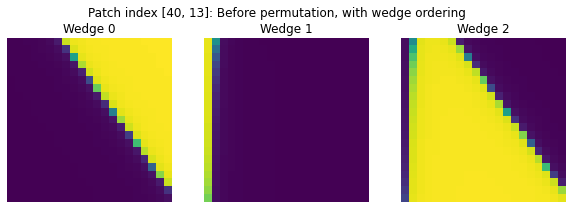

In [26]:
wedges = foj.dists2indicators(dists).detach().cpu().numpy()
# print('wedge shape', wedges.shape)
patch_index = [40,13]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before permutation, with wedge ordering')
plt.subplot(131)
plt.imshow(wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)

angles = params[:, :3, :, :].detach().cpu().numpy()


print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())


print('Original Angles', angles[0,:,patch_index[0],patch_index[1]])

print('Wedge Angles', anglemat[:,patch_index[0],patch_index[1]])

# plt.colorbar()

# print('Wedge Range', np.min(wedges[0,1,:,:,0,0]),np.max(wedges[0,1,:,:,0,0]))

In [27]:
def find_edges(x,d):
    x0,y0 = x
    dx,dx = d
    pm = np.asarray[-1,1]
    tx = (pm-x0)/dx + y0
    ty = (pm-y0)/dx + x0
    return [tx,ty]

In [28]:
angs = angles[0,:,patch_index[0],patch_index[1]]

find_edges(params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy(), [np.cos() ])

TypeError: cos() takes from 1 to 2 positional arguments but 0 were given

In [29]:
H_patches = wedges.shape[4]
W_patches = wedges.shape[5]
N=1

In [30]:
#Use wedges to create region patches, use these patches to create permutations

wedges = foj.dists2indicators(dists).detach().cpu()
region_patches = wedges.unsqueeze(1).unsqueeze(3)
permutations = get_permutations(region_patches)

In [31]:
idxs = resolve_permutations_mrf(permutations, stride=1, neighborhood=8, max_iters=None, func=func, func2=func, seed=[0,0])

In [32]:
idxs.shape

torch.Size([61, 61])

In [33]:
perm_list[idxs].shape

torch.Size([61, 61, 3])

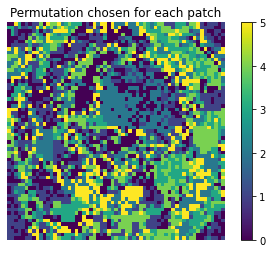

In [34]:
plt.imshow(idxs)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [35]:
perm_tensor = perm_list[idxs].view(1,1,1,1,H_patches,W_patches,3)
perm_tensor = perm_tensor.repeat(1,1,opts.R,opts.R,1,1,1)
perm_tensor.shape 

torch.Size([1, 1, 21, 21, 61, 61, 3])

In [36]:
perm_list[idxs];

In [37]:
wedges = foj.dists2indicators(dists).detach().cpu()


In [38]:
perm_wedges.shape

torch.Size([1, 1, 21, 21, 61, 61, 3])

In [39]:
sort_wedges = perm_wedges[0,0,:,:,idxs]

In [40]:
sort_wedges.shape

torch.Size([21, 21, 61, 61, 61, 3])

In [41]:
idxs.shape

torch.Size([61, 61])

In [42]:
test = torch.tensor([0,1,2]).view(1,1,-1).repeat(28,28,1)
test[perm_list[idxs]].shape

torch.Size([61, 61, 3, 28, 3])

In [43]:
sorted_wedges = torch.gather(perm_wedges, -1, perm_tensor)
sorted_wedges = sorted_wedges.swapdims(1,6).squeeze(-1)
sorted_wedges.shape

torch.Size([1, 3, 21, 21, 61, 61])

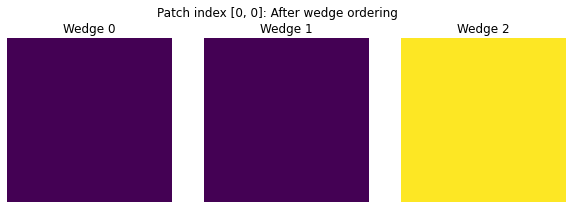

In [44]:

patch_index = [0,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: After wedge ordering')
plt.subplot(131)
plt.imshow(sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)


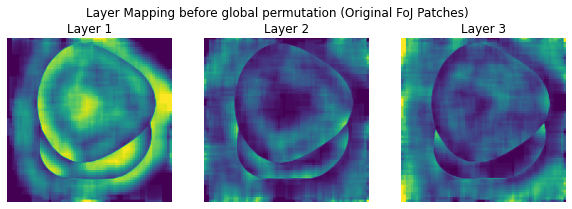

In [45]:
reconstruct_1 = reconstruct_img(wedges[0,0,...],H,W,opts.stride,opts.R)
reconstruct_2 = reconstruct_img(wedges[0,1,...],H,W,opts.stride,opts.R)
reconstruct_3 = reconstruct_img(wedges[0,2,...],H,W,opts.stride,opts.R)

plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(reconstruct_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(reconstruct_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(reconstruct_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('Layer Mapping before global permutation (Original FoJ Patches)')
plt.subplots_adjust(top=1.73)

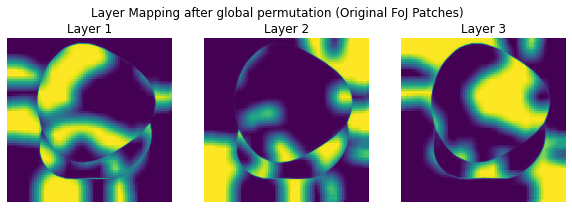

In [46]:
reconstruct_1 = reconstruct_img(sorted_wedges[0,0,...],H,W,opts.stride,opts.R)
reconstruct_2 = reconstruct_img(sorted_wedges[0,1,...],H,W,opts.stride,opts.R)
reconstruct_3 = reconstruct_img(sorted_wedges[0,2,...],H,W,opts.stride,opts.R)

plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(reconstruct_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(reconstruct_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(reconstruct_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('Layer Mapping after global permutation (Original FoJ Patches)')
plt.subplots_adjust(top=1.73)

In [47]:
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))

## Next part: Sort by wedge size

In [48]:
ang_sort_idx = torch.tensor(np.argsort(-anglemat,axis=0))
# angles_ascending = np.take_along_axis(useful_angles, ang_sort_idx, axis=0)
ang_sort_idx = ang_sort_idx.unsqueeze(-1).swapdims(0,3).squeeze(0)
ang_sort_idx = ang_sort_idx.view(1,1,1,1,H_patches,W_patches,3)
ang_sort_idx = ang_sort_idx.repeat(1,1,opts.R,opts.R,1,1,1)
ang_sort_idx.shape

torch.Size([1, 1, 21, 21, 61, 61, 3])

In [49]:
ang_sorted_wedges_resh = torch.gather(perm_wedges, -1, ang_sort_idx)
ang_sorted_wedges = ang_sorted_wedges_resh.swapdims(1,6).squeeze(-1)


In [50]:
ang_region_patches = ang_sorted_wedges.unsqueeze(1).unsqueeze(3)
ang_permutations = get_permutations(ang_region_patches)

In [51]:
ang_idxs = resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1000, func=func, func2=func, seed=[15,15])

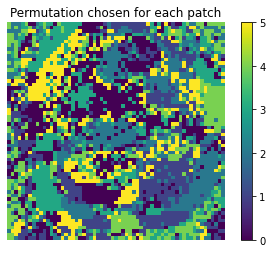

In [52]:
plt.imshow(ang_idxs)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [53]:
ang_perm_tensor = perm_list[ang_idxs].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor = ang_perm_tensor.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_resh = torch.gather(perm_wedges, -1, ang_perm_tensor)
ang_perm_wedges = ang_perm_wedges_resh.swapdims(1,6).squeeze(-1)



Vertex position [[-352.7711  -84.8202]]
Wedge Angles tensor([6.2061, 0.0659, 0.0112])


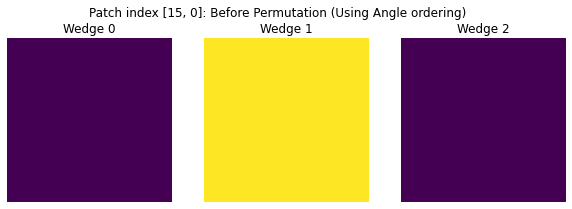

In [54]:
patch_index = [15,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before Permutation (Using Angle ordering)')
plt.subplot(131)
plt.imshow(ang_sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)
print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())
print('Wedge Angles', sorted_angles[:,patch_index[0],patch_index[1]])

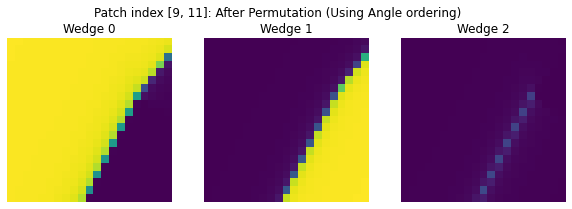

In [55]:
patch_index = [9,11]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: After Permutation (Using Angle ordering)')
plt.subplot(131)
plt.imshow(ang_perm_wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_perm_wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_perm_wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)


In [56]:
ang_idxs[patch_index[0],patch_index[1]]

tensor(3)

## Creating unary potentials

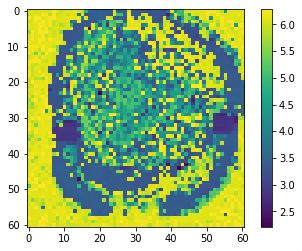

In [57]:
plt.imshow(sorted_angles[0,...].numpy())
plt.colorbar()

In [58]:
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))
epsilon_0 = .3
epsilon_1 = .1
epsilon_2 = .1

out_of_bounds = torch.max(torch.abs(foj.x0y0),axis=1)[0].squeeze(0) 
#Booleans representing the conditionals
w0_pi = torch.abs(sorted_angles[0,...]-np.pi)<epsilon_0
i_w0_pi = torch.abs(sorted_angles[0,...]-np.pi)>epsilon_1
w1_pi = torch.abs(sorted_angles[1,...]-np.pi)<epsilon_1
w2_zero = sorted_angles[2,...]<epsilon_2

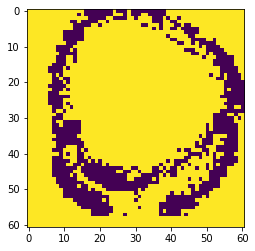

In [59]:
plt.imshow((out_of_bounds>1).cpu().numpy())

In [60]:
w0_pi.cpu().numpy()[3,25]

False

In [61]:
sorted_angles[:,3,15]

tensor([3.4218e+00, 2.8610e+00, 4.0340e-04])

Text(0.5, 1.0, 'Case 3')

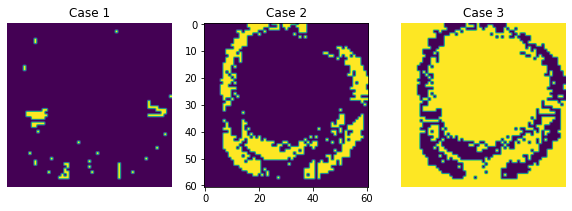

In [62]:
# plt.imshow(w0_pi.numpy())
# plt.imshow((out_of_bounds>1).numpy())
# plt.imshow(out_of_bounds.numpy())

# plt.imshow(w2_zero.numpy())
# torch.sum(w2_zero)


#Locations of Case 1 w0 -> pi, w2 !-> 0
plt.figure(figsize = [10,30])
plt.subplot(131)
plt.imshow(w0_pi.cpu().numpy()&  ~w2_zero.cpu().numpy()&(out_of_bounds<1).cpu().numpy())
plt.axis('off')
plt.title('Case 1')

#Locations of Case 2  w2 -> 0
plt.subplot(132)
plt.imshow(w2_zero.cpu().numpy() &~w1_pi.cpu().numpy()&(out_of_bounds<1).cpu().numpy())
# plt.axis('off')
plt.title('Case 2')

#Locations of Case 3  w0 !-> pi, w2 !-> 0
plt.subplot(133)
plt.imshow((~w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy())|(out_of_bounds>1).cpu().numpy())
plt.axis('off')
plt.title('Case 3')

In [63]:
unary_pots = np.zeros((6,*w2_zero.cpu().numpy().shape))
unary_pots[:,w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy()] = np.array([[0,0,1,1,1,1]]).T
unary_pots[:,w2_zero.cpu().numpy()] = np.array([[0,0,0,1,1,1]]).T
unary_pots[:,~w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy()] = np.array([[0,0,0,0,0,0]]).T

#Inverting
unary_pots = np.zeros((6,*w2_zero.cpu().numpy().shape)) 
unary_pots[:,w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy()] = np.array([[1,1,0,0,0,0]]).T
unary_pots[:,w2_zero.cpu().numpy()&~w1_pi.cpu().numpy()] = np.array([[0,0,1,1,0,1]]).T
unary_pots[:,(~w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy())|(out_of_bounds>1).cpu().numpy()] = np.array([[0,0,0,0,0,0]]).T

In [64]:
unary_pots.shape

(6, 61, 61)

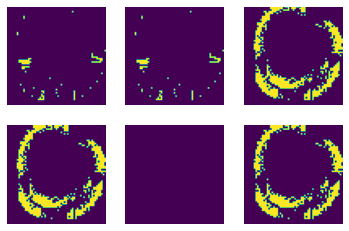

In [65]:
for itr in range(unary_pots.shape[0]):
    plt.subplot(2,3,itr+1)
    plt.imshow(unary_pots[itr,:,:])
    plt.axis('off')

In [210]:
def unary_func(max_iters,t):
    return np.sqrt(max_iters-t)/np.sqrt(max_iters)

ang_idxs_unary = resolve_permutations_mrf(ang_permutations, stride=3, neighborhood=8, max_iters=1000,unary = .01*unary_pots, unary_func = unary_func, func=func, func2=func, seed=[15,0])

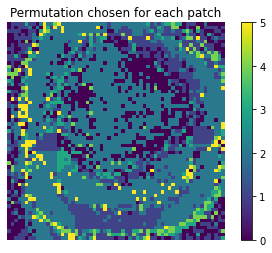

In [211]:
plt.imshow(ang_idxs_unary)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [212]:
ang_perm_tensor_unary = perm_list[ang_idxs_unary].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor_unary = ang_perm_tensor_unary.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_unary = torch.gather(ang_sorted_wedges_resh, -1, ang_perm_tensor_unary)
ang_perm_wedges_unary = ang_perm_wedges_unary.swapdims(1,6).squeeze(6)


In [213]:
ang_idxs_unary[16,0]
unary_pots[:,16,0]

array([0., 0., 0., 0., 0., 0.])

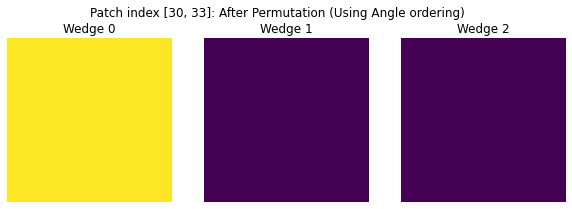

In [214]:
# @interactive
def plot_wedges(patch_idx_x =27, patch_idx_y = 0):
    patch_index = [patch_idx_x,patch_idx_y]
    plt.figure(figsize=[10,30])
    plt.suptitle(f'Patch index {patch_index}: After Permutation (Using Angle ordering)')
    plt.subplot(131)
    plt.imshow(ang_perm_wedges_unary[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 0')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(ang_perm_wedges_unary[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 1')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(ang_perm_wedges_unary[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 2')
    plt.axis('off')
    plt.subplots_adjust(top=1.73)


plot_wedges(patch_idx_x = 25+itr, patch_idx_y = 33)

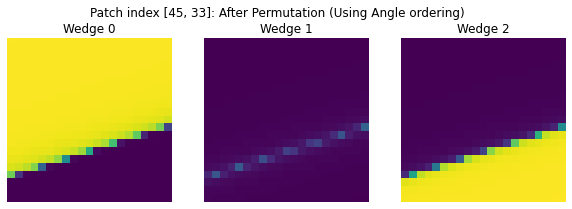

In [215]:
plot_wedges(patch_idx_x = 45, patch_idx_y = 33)

In [216]:
def reconstruct_img(out,H,W,stride,PSZ):
    rec = np.zeros([H,W,int(out.shape[-2]*out.shape[-1])])
    num_overlaps = np.zeros([H,W])
    itr = 0
    for i in range(out.shape[-2]):
        for j in range(out.shape[-1]):
            rec[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out[...,i,j].detach().cpu().numpy()
            num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
            itr = itr+1
    return np.divide(np.sum(rec,axis = -1),num_overlaps)


In [217]:
ang_perm_wedges_unary[0,0,...].shape

torch.Size([21, 21, 61, 61])

In [218]:
np.argwhere(unary_pots[0,:,:] == 1)

array([[ 3, 40],
       [ 6, 10],
       [ 7, 10],
       [16,  6],
       [17,  6],
       [27, 60],
       [29, 52],
       [30, 52],
       [31, 52],
       [31, 53],
       [31, 54],
       [31, 55],
       [32, 13],
       [32, 14],
       [32, 55],
       [32, 56],
       [32, 57],
       [32, 58],
       [33,  7],
       [33,  8],
       [33,  9],
       [33, 10],
       [33, 11],
       [33, 12],
       [33, 13],
       [33, 57],
       [33, 58],
       [34,  7],
       [34,  8],
       [34,  9],
       [34, 10],
       [34, 11],
       [34, 12],
       [34, 13],
       [34, 14],
       [34, 52],
       [34, 53],
       [34, 54],
       [34, 55],
       [34, 56],
       [34, 57],
       [35,  9],
       [35, 10],
       [35, 11],
       [35, 12],
       [35, 13],
       [37,  9],
       [37, 10],
       [37, 11],
       [37, 12],
       [37, 13],
       [38,  9],
       [38, 10],
       [40, 11],
       [41, 58],
       [44, 26],
       [46, 55],
       [48,  8],
       [48, 33

Vertex position [[  2.9410093 -17.086115 ]]
Wedge Angles tensor([6.0807, 0.1873, 0.0152])
Permutation tensor(2)


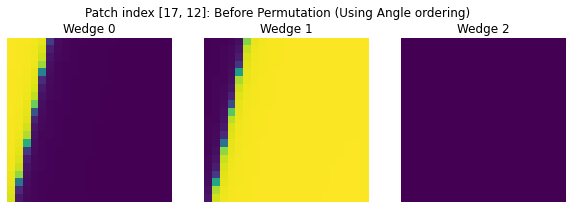

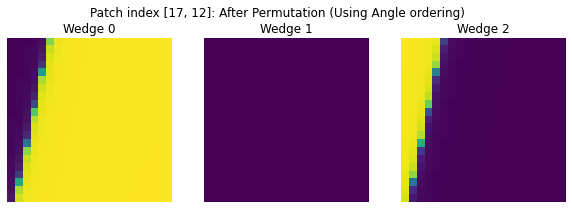

In [219]:
patch_index = [17,12]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before Permutation (Using Angle ordering)')
plt.subplot(131)
plt.imshow(ang_sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)
print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())
print('Wedge Angles', sorted_angles[:,patch_index[0],patch_index[1]])
print('Permutation', ang_idxs_unary[patch_index[0],patch_index[1]])

plot_wedges(patch_idx_x = patch_index[0], patch_idx_y = patch_index[1])

In [220]:
wedge_out_unary_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],H,W,opts.stride,opts.R)
wedge_out_1 =  reconstruct_img(ang_perm_wedges[0,0,...],H,W,opts.stride,opts.R)

Text(0.5, 1.0, 'Without Unary Potentials')

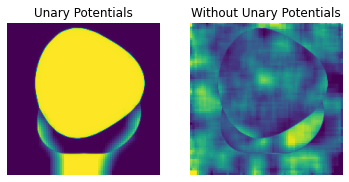

In [221]:
plt.subplot(121)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Unary Potentials')
plt.subplot(122)
plt.imshow(wedge_out_1,vmin=0,vmax=1)
plt.axis('off')
plt.title('Without Unary Potentials')


Text(0.5, 1.0, 'Layer 3')

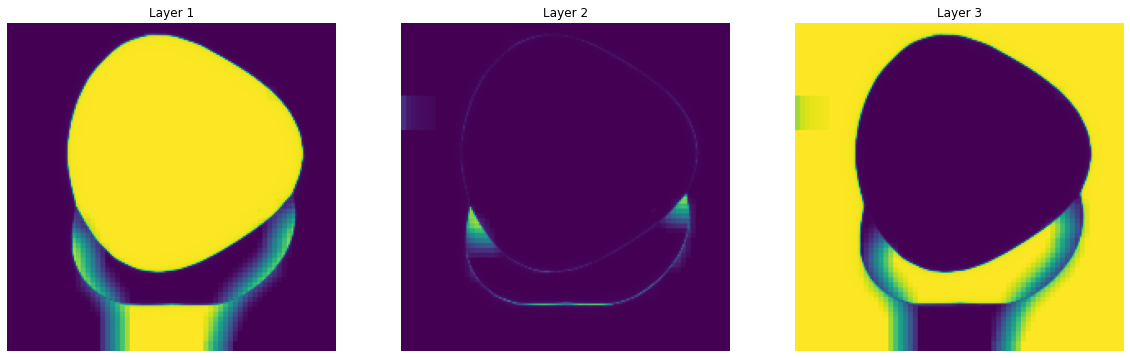

In [228]:
wedge_out_unary_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],H,W,opts.stride,opts.R)
wedge_out_unary_2 = reconstruct_img(ang_perm_wedges_unary[0,1,...],H,W,opts.stride,opts.R)
wedge_out_unary_3 = reconstruct_img(ang_perm_wedges_unary[0,2,...],H,W,opts.stride,opts.R)
plt.figure(figsize=[20,60])
plt.subplot(131)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(wedge_out_unary_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(wedge_out_unary_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')

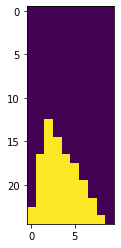

In [223]:
plt.imshow(wedge_out_unary_2[100:125,40:50] >.5 )

In [224]:
wedge_out_unary_2[116,42]

0.8379895700467275

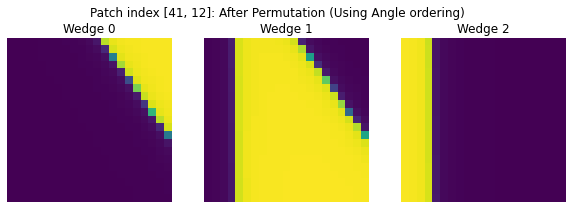

In [225]:
plot_wedges(patch_idx_x = int(116/3)+3  , patch_idx_y = int(42/3)-2)

In [ ]:
permutations[:, :, :, stride:, :, :-1].unsqueeze(2) -
                              permutations[:, :, :, :-stride, :, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(2)

In [120]:
ang_permutations.shape

torch.Size([3, 6, 21, 21, 61, 61])

In [121]:
ang_permutations[:, :, :, 1:, :, :-1].shape

torch.Size([3, 6, 21, 20, 61, 60])

In [332]:
def local_resolve_permutations_mrf(permutations, stride, neighborhood=4, unary = None, unary_func = None, max_iters=None, func=None, func2=None, seed=None):
    """
    #region_patches has shape [1, 1, 3, 1, RF, RF, H_patches, W_patches]
    permutations has shape [3, 6, RF, RF, H_patches, W_patches]
    """

    assert neighborhood in [4, 8], "neighborhood must be 4 or 8"

    H_patches = permutations.shape[-2]
    W_patches = permutations.shape[-1]

    RF = permutations.shape[-3]
    assert permutations.shape[-4] == RF, "RF must be square"

    if func is None:
        func = lambda x: 10.0 * torch.exp(-100.0 * x)

    if func2 is None:
        func2 = lambda x: 10.0 * torch.exp(-100.0 * x)

    if max_iters is None:
        max_iters = 2 * max([W_patches, H_patches])

    # Create a 6x6xHx(W-1) array of log pairwise potentials for horizontal edges
    # and a 6x6x(H-1)xW array for vertical ones.

    # horizontal_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i, j+1) patches evaluated at
    # the kth and lth permutation respectively.
    horizontal_logpsi = func((permutations[:, :, :, stride:, :, :-1].unsqueeze(2) -
                              permutations[:, :, :, :-stride, :, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

    # vertical_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j) patches evaluated at
    # the kth and lth permutation respectively.
    vertical_logpsi = func((permutations[:, :, stride:, :, :-1, :].unsqueeze(2) -
                            permutations[:, :, :-stride, :, 1:, :].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

    # Add padding to avoid having to deal with image boundaries
    horizontal_logpsi = torch.nn.functional.pad(horizontal_logpsi, pad=(1, 1, 1, 1))
    vertical_logpsi = torch.nn.functional.pad(vertical_logpsi, pad=(1, 1, 1, 1))

    if neighborhood == 8:
        # angle45_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j+1) patches evaluated at
        # the kth and lth permutations respectively.
        angle45_logpsi = func2((permutations[:, :, stride:, stride:, :-1, :-1].unsqueeze(2) -
                                permutations[:, :, :-stride, :-stride, 1:, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(
            2))

        # angle135_logpsi[k, l, i, j] is the log psi function between the (i, j+1) and (i+1, j) patches evaluated at
        # the kth and lth permutations respectively. [Note: This is a shifted version of the match between (i, j) and (i+1, j-1).]
        angle135_logpsi = func2((permutations[:, :, stride:, :-stride, :-1, 1:].unsqueeze(2) -
                                 permutations[:, :, :-stride, stride:, 1:, :-1].unsqueeze(1)).abs().sum(0).mean(2).mean(
            2))

        # Add padding to avoid having to deal with image boundaries
        angle45_logpsi = torch.nn.functional.pad(angle45_logpsi, pad=(1, 1, 1, 1))
        angle135_logpsi = torch.nn.functional.pad(angle135_logpsi, pad=(1, 1, 1, 1))

    # Set all distributions to uniform except seed which is set to [1, 0, 0, 0, 0, 0].
    lmbdas = torch.ones((6, H_patches + 2, W_patches + 2), dtype=torch.float32).to(permutations.device) / 6.0

    # Unless specified, set seed to the non-constant patch closest to center
    if seed is None:
        # Find patches with at least 2 colors (i.e. no uniform region)
        good_patches = permutations[:, 0, :, :, :, :].max(dim=-3)[0].max(dim=-3)[0].sum(0) > 1.5

        # Find closest such patch to the center
        good_patch_inds = good_patches.nonzero()
        if len(good_patch_inds.shape) < 2:
            seed = (H_patches // 2, W_patches // 2)
        else:
            gpiy = good_patch_inds[:, 0] - (H_patches - 1) / 2.0
            gpix = good_patch_inds[:, 1] - (W_patches - 1) / 2.0
            ind = torch.argmin(gpix ** 2 + gpiy ** 2)

            seed = good_patch_inds[ind, :]

    lmbdas[0, seed[0] + 1, seed[1] + 1] = 1.0
    lmbdas[1:, seed[0] + 1, seed[1] + 1] = 0.0
    for t in range(max_iters):
        if unary is not None:
            t1 = lmbdas[:, 1:-1, 1:-1] == torch.max(lmbdas[:, 1:-1, 1:-1],0)[0].unsqueeze(0).repeat(6,1,1)
            t2 = unary == torch.max(unary,0)[0].unsqueeze(0).repeat(6,1,1)
            #Logical intersect tells if argmax of q_j and the potential at j are equal
            #Second term exculdes suprious equalities (when many of the q_j are the same (happens a lot at init))
            logical_intersect = torch.max(t1*t2,0)[0] *(t1.sum(dim=0)>1)
#             lmbdas[:, 1:-1, 1:-1] += unary * ((max_iters-t)/max_iters) #Product term to reduce strength of prior over time
            lmbdas[:, 1:-1, 1:-1] += unary * unary_func(max_iters,t) #* ~logical_intersect
            lmbdas /= lmbdas.sum(dim=0, keepdim=True)
        # Left neighbor:   sum over permutations of the (i, j-1)th patch, i.e. dimension 0
        s = (lmbdas.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).sum(dim=0)
        # Right neighbor:  sum over permutations of the (i, j+1)th patch, i.e. dimension 1
        s += (lmbdas.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).sum(dim=1)
        # Top neighbor:    sum over permutations of the (i-1, j)th patch, i.e. dimension 0
        s += (lmbdas.unsqueeze(1)[:, :, :-2, 1:-1] * vertical_logpsi[:, :, :-1, 1:-1]).sum(dim=0)
        # Bottom neighbor: sum over permutations of the (i+1, j)th patch, i.e. dimension 1
        s += (lmbdas.unsqueeze(0)[:, :, 2:, 1:-1] * vertical_logpsi[:, :, 1:, 1:-1]).sum(dim=1)

        if neighborhood == 8:
            # TL neighbor: sum over permutations of the (i-1, j-1)th patch, i.e. dimension 0
            s += (lmbdas.unsqueeze(1)[:, :, :-2, :-2] * angle45_logpsi[:, :, :-1, :-1]).sum(dim=0)
            # BR neighbor: sum over permutations of the (i+1, j+1)th patch, i.e. dimension 1
            s += (lmbdas.unsqueeze(0)[:, :, 2:, 2:] * angle45_logpsi[:, :, 1:, 1:]).sum(dim=1)
            # TR neighbor: sum over permutations of the (i-1, j+1)th patch, i.e. dimension 0
            s += (lmbdas.unsqueeze(1)[:, :, :-2, 2:] * angle135_logpsi[:, :, :-1, 1:]).sum(dim=0)
            # BL neighbor: sum over permutations of the (i+1, j-1)th patch, i.e. dimension 1
            s += (lmbdas.unsqueeze(0)[:, :, 2:, :-2] * angle135_logpsi[:, :, 1:, :-1]).sum(dim=1)

        # Update parameters according to CAVI update
        lmbdas[:, 1:-1, 1:-1] = torch.exp(s)


        # Normalize and reset top-left distribution

        lmbdas /= lmbdas.sum(dim=0, keepdim=True)


        lmbdas[0, seed[0] + 1, seed[1] + 1] = 1.0
        lmbdas[1:, seed[0] + 1, seed[1] + 1] = 0.0

    lmbdas = lmbdas[:, 1:-1, 1:-1]

    indices = lmbdas.argmax(0)  # shape [H_patches, W_patches]

    return indices

In [333]:
def unary_func(max_iters,t):
    return np.sqrt(max_iters-t)/np.sqrt(max_iters)
def func(x):
    x = -x.abs()
    mult = torch.exp(-30.0 * x.max(0, keepdim=True)[0].max(1, keepdim=True)[0] ** 2)
    return mult * torch.exp(3.0 * x*.1)

ang_idxs_unary = local_resolve_permutations_mrf(ang_permutations, stride=3, neighborhood=8, max_iters=1000,unary = torch.tensor(.00001*unary_pots), unary_func = unary_func, func=func, func2=func, seed=[27,0])

Text(0.5, 1.0, 'Layer 3')

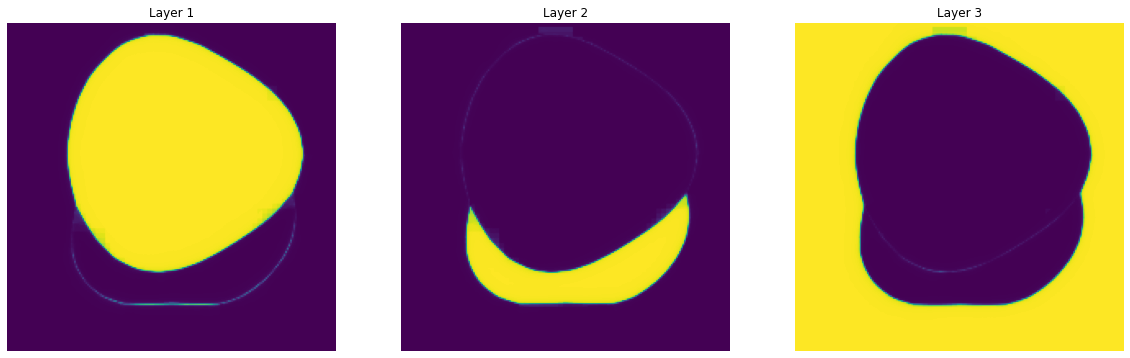

In [334]:
ang_perm_tensor_unary = perm_list[ang_idxs_unary].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor_unary = ang_perm_tensor_unary.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_unary = torch.gather(ang_sorted_wedges_resh, -1, ang_perm_tensor_unary)
ang_perm_wedges_unary = ang_perm_wedges_unary.swapdims(1,6).squeeze(6)

wedge_out_unary_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],H,W,opts.stride,opts.R)
wedge_out_unary_2 = reconstruct_img(ang_perm_wedges_unary[0,1,...],H,W,opts.stride,opts.R)
wedge_out_unary_3 = reconstruct_img(ang_perm_wedges_unary[0,2,...],H,W,opts.stride,opts.R)
plt.figure(figsize=[20,60])
plt.subplot(131)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(wedge_out_unary_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(wedge_out_unary_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')